In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from utils.data import load_tc_data
from utils.plot import make_cmap
import cftime as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from netCDF4 import Dataset
from numpy import inf
from scipy.stats import gaussian_kde
import matplotlib.colors as mcolors
from scipy import stats
import matplotlib.pyplot as plt
import tropycal
from tropycal import tracks


In [3]:

inputs = np.load('/user/work/al18709/tc_data_flipped/KE_tracks/valid_X.npy')
training_inputs = np.load('/user/work/al18709/tc_data_flipped/KE_tracks/train_X.npy')


In [4]:
# for model in ['canesm','cnrm6','ecearth6','ipsl6','miroc6','mpi6','mri6','ukmo'][0]:
for model in ['canesm','cnrm6','ecearth6','ipsl6','miroc6','mpi6','mri6','ukmo']:
	for scenario in ['hist','ssp245','ssp585']:
		# globals()[f'{model}_topography_{scenario}'] = np.load(f'/user/home/al18709/work/ke_track_inputs/{model}_{scenario}_topography.npy')
		print(model,scenario)
		globals()[f'{model}_tracks_{scenario}'] = pd.read_csv(f'/user/home/al18709/work/ke_track_inputs/{model}_{scenario}_tracks.csv')
		



canesm hist
canesm ssp245
canesm ssp585
cnrm6 hist
cnrm6 ssp245
cnrm6 ssp585
ecearth6 hist
ecearth6 ssp245
ecearth6 ssp585
ipsl6 hist
ipsl6 ssp245
ipsl6 ssp585
miroc6 hist
miroc6 ssp245
miroc6 ssp585
mpi6 hist
mpi6 ssp245
mpi6 ssp585
mri6 hist
mri6 ssp245
mri6 ssp585
ukmo hist
ukmo ssp245
ukmo ssp585


In [30]:
ibtracs = tracks.TrackDataset(basin='all',source='ibtracs',ibtracs_mode='jtwc_neumann',catarina=True,ibtracs_url="/user/work/al18709/ibtracks/ibtracs.ALL.list.v04r00.csv")

--> Starting to read in ibtracs data


--> Completed reading in ibtracs data (19.84 seconds)


number of storms
--> Getting filtered storm tracks


--> Grouping by lat/lon/storm
--> Generating plot


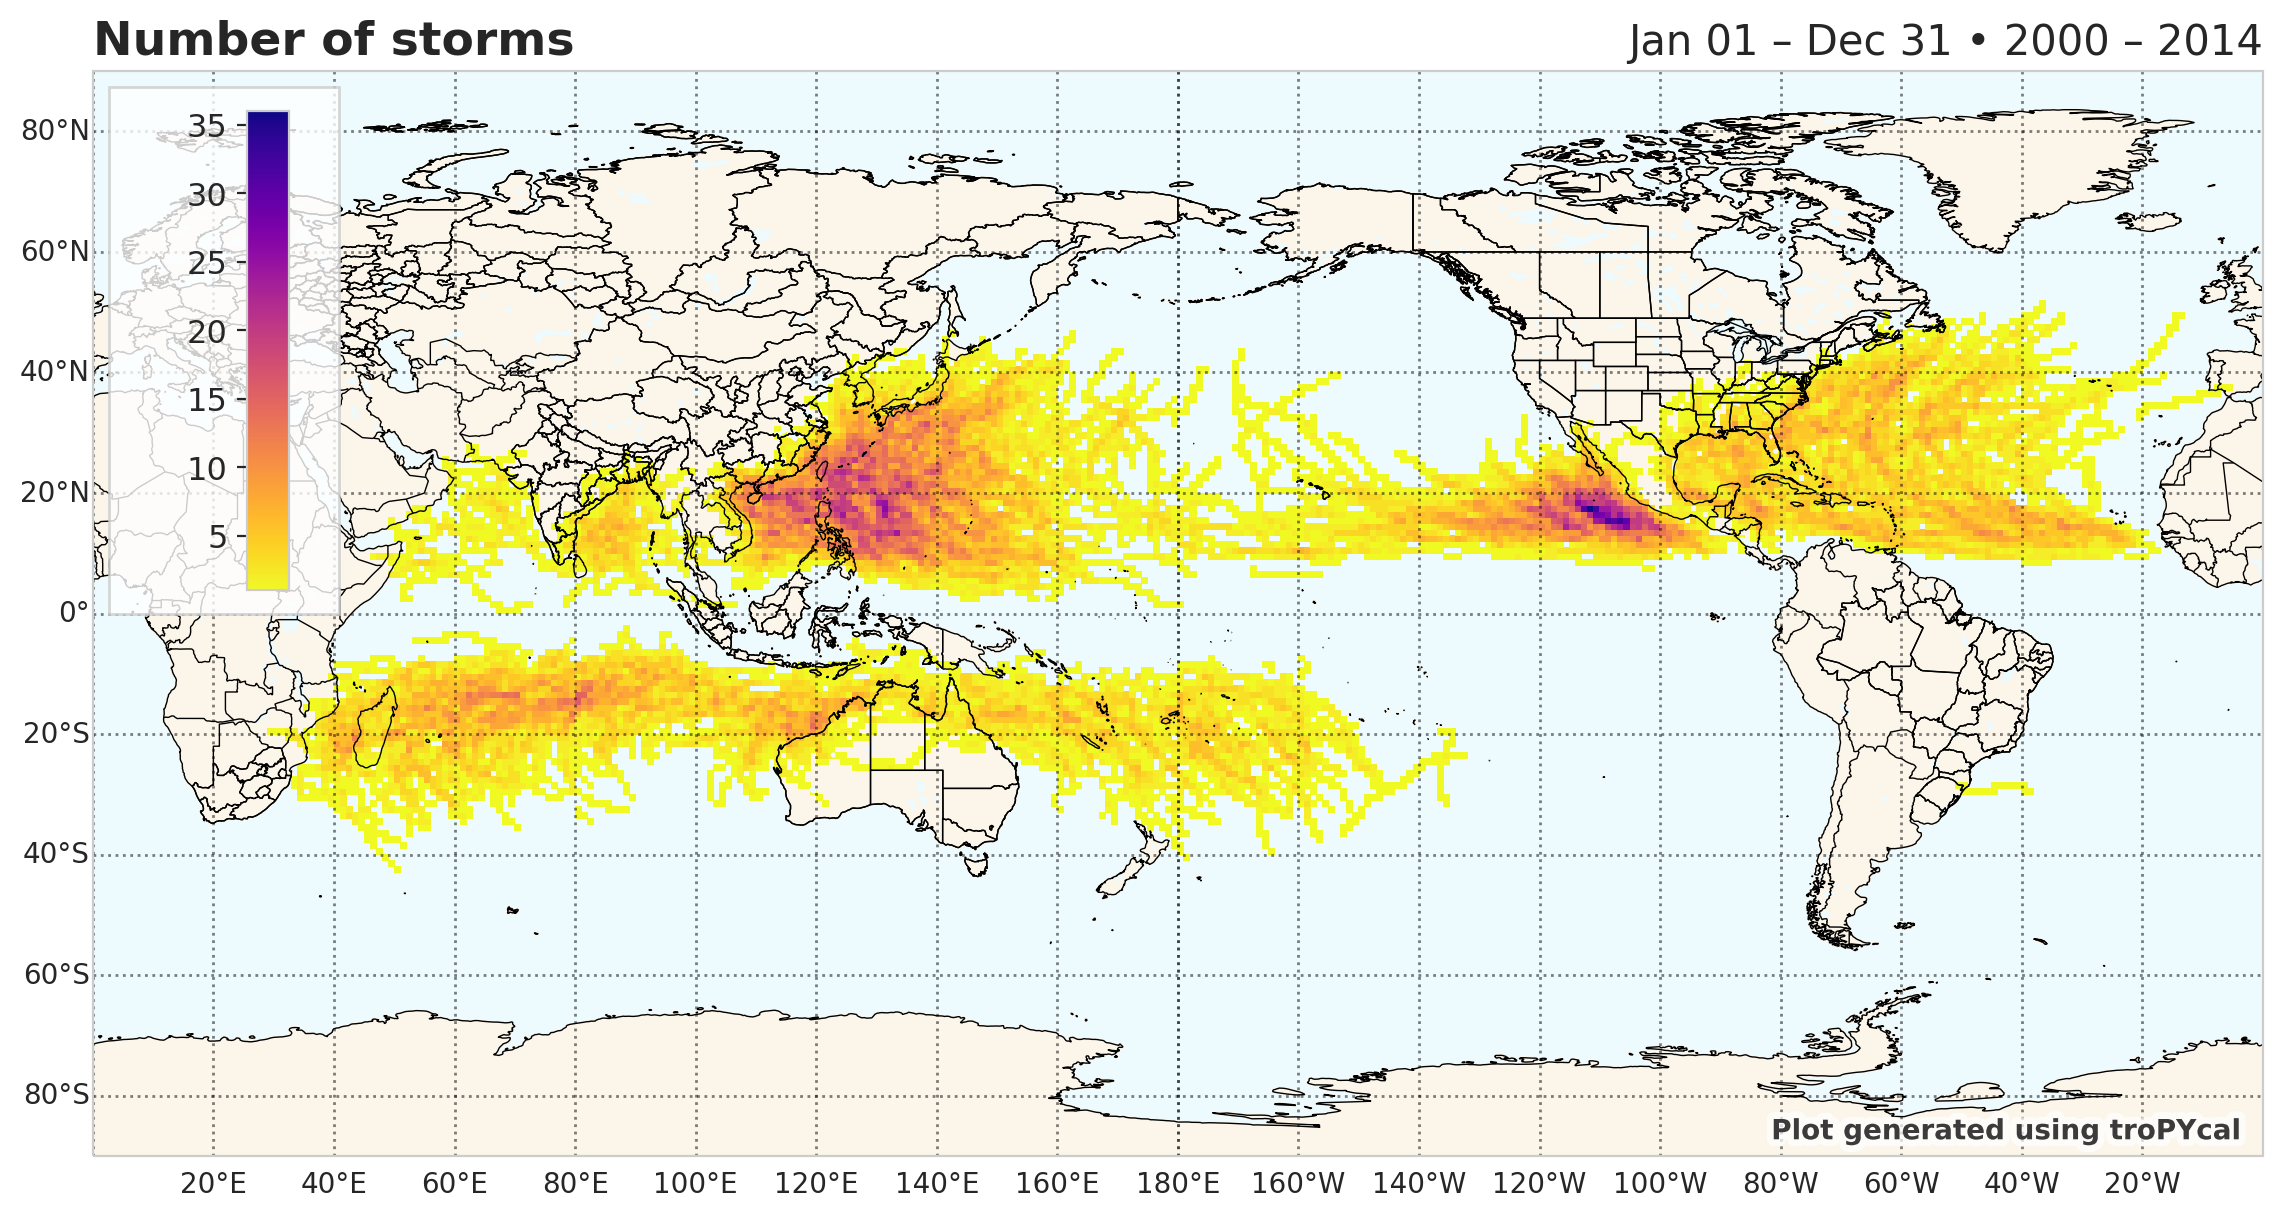

In [35]:
ibtracs.gridded_stats(request="number of storms",prop={'cmap':'plasma_r'},year_range=(2000,2014))
plt.savefig('ibtracs_density.png',bbox_inches='tight',dpi=300)

In [10]:
binsize = 1
def to_bin(x): return np.floor(x / binsize) * binsize
def calc_track_density(storm_data,lonshift=False):
    binsize = 1
    latbin = storm_data.lat.map(to_bin)
    lonbin = storm_data.lon.map(to_bin)
    new_df = pd.DataFrame({'latbin': latbin, 'lonbin': lonbin, 'stormid':storm_data.sid})
    new_new_df = new_df.drop_duplicates()
    if lonshift == True:
        lat_bins = np.arange(-90, 91, 1)
        lon_bins = np.arange(-180, 181, 1)
    else:
        lat_bins = np.arange(-90, 91, 1)
        lon_bins = np.arange(0, 361, 1)
    density, _, _ = np.histogram2d(new_new_df.latbin, new_new_df.lonbin, bins=[lat_bins, lon_bins])
    masked_density = np.ma.masked_equal(density, 0)
    return masked_density


In [11]:
(canesm_tracks_hist.year >= 2000) & (canesm_tracks_hist.year <= 2014)

0         False
1         False
2         False
3         False
4         False
          ...  
362749     True
362750     True
362751     True
362752     True
362753     True
Name: year, Length: 362754, dtype: bool

In [12]:
# Compute histogram of cyclone tracks
['canesm','cnrm6','ecearth6','ipsl6','miroc6','mpi6','mri6','ukmo']
canesm_hist_masked_density = calc_track_density(canesm_tracks_hist[(canesm_tracks_hist.year >= 2000) & (canesm_tracks_hist.year <= 2014)])
cnrm6_hist_masked_density = calc_track_density(cnrm6_tracks_hist[(cnrm6_tracks_hist.year >= 2000) & (cnrm6_tracks_hist.year <= 2014)])
ecearth6_hist_masked_density = calc_track_density(ecearth6_tracks_hist[(ecearth6_tracks_hist.year >= 2000) & (ecearth6_tracks_hist.year <= 2014)])
ipsl6_hist_masked_density = calc_track_density(ipsl6_tracks_hist[(ipsl6_tracks_hist.year >= 2000) & (ipsl6_tracks_hist.year <= 2014)])
miroc6_hist_masked_density = calc_track_density(miroc6_tracks_hist[(miroc6_tracks_hist.year >= 2000) & (miroc6_tracks_hist.year <= 2014)])
mpi6_hist_masked_density = calc_track_density(mpi6_tracks_hist[(mpi6_tracks_hist.year >= 2000) & (mpi6_tracks_hist.year <= 2014)])
mri6_hist_masked_density = calc_track_density(mri6_tracks_hist[(mri6_tracks_hist.year >= 2000) & (mri6_tracks_hist.year <= 2014)])
ukmo_hist_masked_density = calc_track_density(ukmo_tracks_hist[(ukmo_tracks_hist.year >= 2000) & (ukmo_tracks_hist.year <= 2014)])


In [13]:
mswep_sids = pd.read_csv('/user/home/al18709/work/CMIP6/MSWEP/storm_rain/storm_sid_NH.csv')
indices = (mswep_sids['year'] >= 2000) & (mswep_sids['year'] <= 2014)
mswep_sids = mswep_sids[indices].reset_index()
meta_mswep = pd.DataFrame({'sid':mswep_sids.sid ,'lat':mswep_sids.centre_lat, 'lon':mswep_sids.centre_lon, 'hour':mswep_sids.hour, 'year':mswep_sids.year})


In [14]:
mswep_sids

,index,Unnamed: 0,sid,year,month,day,hour,centre_lat,centre_lon
0,27433,27437,2000003S13082,2000,1,8,0,-15.9000,74.7667
1,27434,27438,2000003S13082,2000,1,8,3,-16.1667,74.0869
2,27435,27439,2000003S13082,2000,1,8,6,-16.4333,73.3667
3,27436,27440,2000003S13082,2000,1,8,9,-16.6150,72.6556
4,27437,27441,2000003S13082,2000,1,8,12,-16.7667,72.0000
...,...,...,...,...,...,...,...,...,...
18116,45549,45555,2014356S08101,2014,12,30,18,-18.6500,88.5000
18117,45550,45556,2014356S08101,2014,12,30,21,-18.9860,88.1996
18118,45551,45557,2014356S08101,2014,12,31,0,-19.3000,87.9000
18119,45552,45558,2014356S08101,2014,12,31,3,-19.6211,87.5123


In [15]:

ibtracs_masked_density = calc_track_density(meta_mswep,lonshift=True)

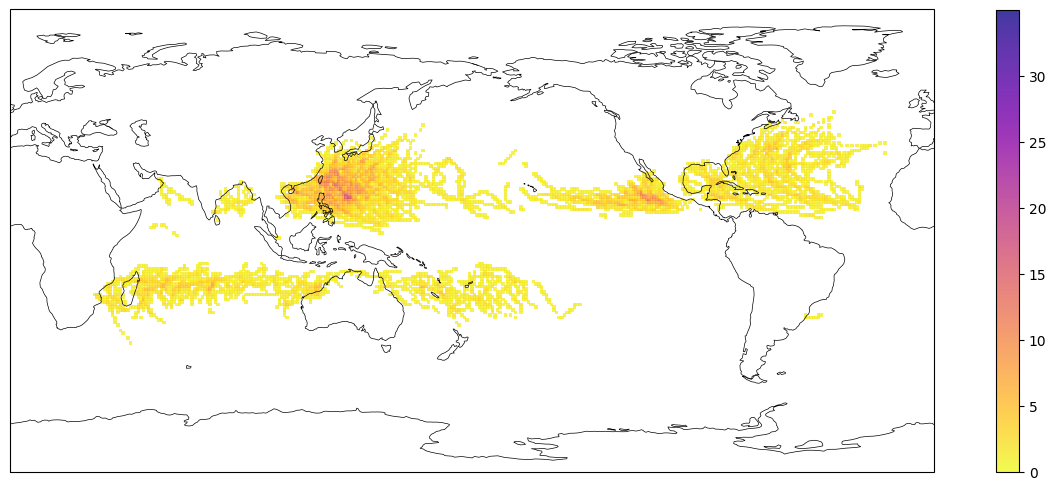

In [16]:
fig, ax = plt.subplots(1,1, figsize=(16, 6),subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
im = ax.pcolor(np.arange(-180,180),np.arange(-90,90),ibtracs_masked_density, transform=ccrs.PlateCarree(),alpha=0.8,cmap='plasma_r',vmin=0,
                        vmax=35)
ax.add_feature(cfeature.COASTLINE,linewidth=0.5) 
ax.set_global()
plt.colorbar(im,ticks=range(0,35,5),ax=ax)
plt.savefig('ibtrack_density.png',bbox_inches='tight',dpi=300)

In [17]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

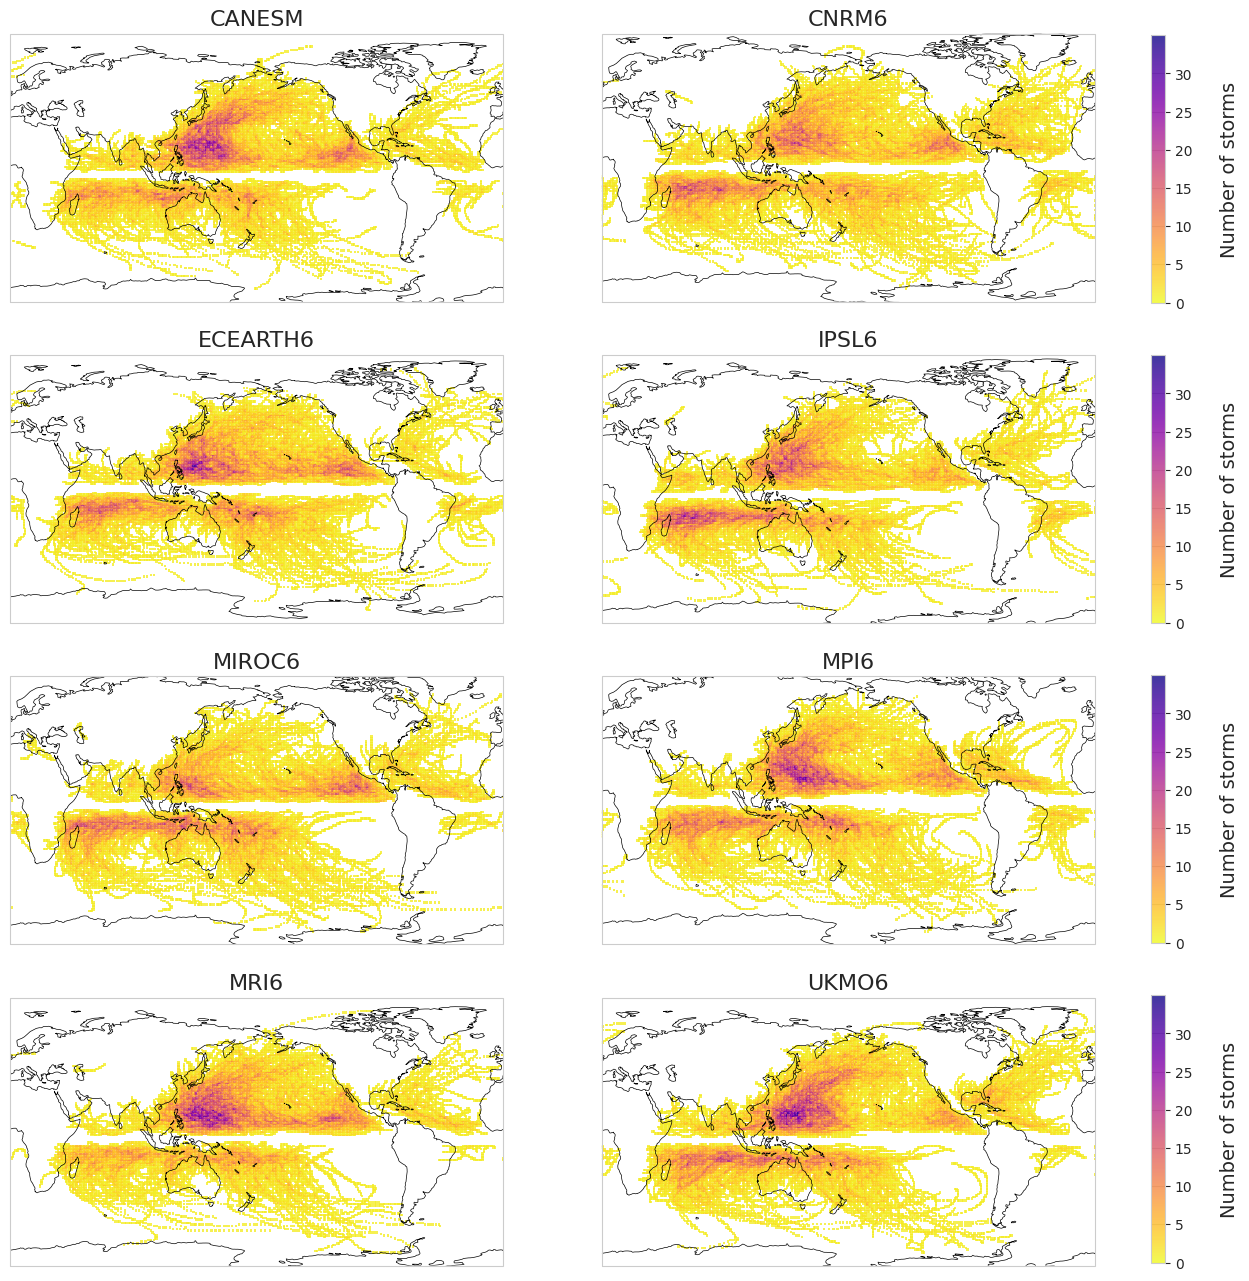

In [34]:
sns.set_style("whitegrid")  # You can change the style to your preference
fig, axes = plt.subplots(4, 2, figsize=(14, 16),gridspec_kw={'width_ratios': [1, 1]},subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
# titles = ['Mean Sea level pressure (hPa)', 'U 850 hPa ($ms^{-1}$)', 'V 850 hPa ($ms^{-1}$)', 'Wind shear', 'Latitude (degrees North)', 'Longitude (degrees East)']
# labels = ['a.','b.','c.','d.','e.','f.']

vmax = 35 
im = axes[0,0].pcolor(np.arange(0,360),np.arange(-90,90),canesm_hist_masked_density, transform=ccrs.PlateCarree(),alpha=0.8,cmap='plasma_r',vmin=0,
                        vmax=vmax)
axes[0,0].set_title('CANESM',fontsize=16)

im = axes[0,1].pcolor(np.arange(0,360),np.arange(-90,90),cnrm6_hist_masked_density, transform=ccrs.PlateCarree(),alpha=0.8,cmap='plasma_r',vmin=0,
                        vmax=vmax)
axes[0,1].set_title('CNRM6',fontsize=16)

im = axes[1,0].pcolor(np.arange(0,360),np.arange(-90,90),ecearth6_hist_masked_density, transform=ccrs.PlateCarree(),alpha=0.8,cmap='plasma_r',vmin=0,
                        vmax=vmax)
axes[1,0].set_title('ECEARTH6',fontsize=16)

im = axes[1,1].pcolor(np.arange(0,360),np.arange(-90,90),ipsl6_hist_masked_density, transform=ccrs.PlateCarree(),alpha=0.8,cmap='plasma_r',vmin=0,
                        vmax=vmax)
axes[1,1].set_title('IPSL6',fontsize=16)

im = axes[2,0].pcolor(np.arange(0,360),np.arange(-90,90),miroc6_hist_masked_density, transform=ccrs.PlateCarree(),alpha=0.8,cmap='plasma_r',vmin=0,
                        vmax=vmax)
axes[2,0].set_title('MIROC6',fontsize=16)

im = axes[2,1].pcolor(np.arange(0,360),np.arange(-90,90),mpi6_hist_masked_density, transform=ccrs.PlateCarree(),alpha=0.8,cmap='plasma_r',vmin=0,
                        vmax=vmax)
axes[2,1].set_title('MPI6',fontsize=16)

im = axes[3,0].pcolor(np.arange(0,360),np.arange(-90,90),mri6_hist_masked_density, transform=ccrs.PlateCarree(),alpha=0.8,cmap='plasma_r',vmin=0,
                        vmax=vmax)
axes[3,0].set_title('MRI6',fontsize=16)

im = axes[3,1].pcolor(np.arange(0,360),np.arange(-90,90),ukmo_hist_masked_density, transform=ccrs.PlateCarree(),alpha=0.8,cmap='plasma_r',vmin=0,
                        vmax=vmax)
axes[3,1].set_title('UKMO6',fontsize=16)

for ax in [axes[0,0],axes[0,1],axes[1,0],axes[1,1],axes[2,0],axes[2,1],axes[3,0],axes[3,1]]:
    ax.add_feature(cfeature.COASTLINE,linewidth=0.5)   
    ax.set_aspect('auto', adjustable=None)


# divider = make_axes_locatable(axes[0,1])
# cax1 = divider.append_axes("right", size="5%", pad=0.05)
# fig.colorbar(im, cax=cax1)
# add colourbar
cbar_ax = fig.add_axes([0.94, 0.712, 0.01, 0.167])
cb = fig.colorbar(im, cax=cbar_ax,shrink=0.005,ticks=range(0,35,5)).set_label(label='Number of storms',size=14, labelpad=20)
cbar_ax = fig.add_axes([0.94, 0.512, 0.01, 0.167])
cb = fig.colorbar(im, cax=cbar_ax,shrink=0.005,ticks=range(0,35,5)).set_label(label='Number of storms',size=14, labelpad=20)
cbar_ax = fig.add_axes([0.94, 0.312, 0.01, 0.167])
cb = fig.colorbar(im, cax=cbar_ax,shrink=0.005,ticks=range(0,35,5)).set_label(label='Number of storms',size=14, labelpad=20)
cbar_ax = fig.add_axes([0.94, 0.112, 0.01, 0.167])
cb = fig.colorbar(im, cax=cbar_ax,shrink=0.005,ticks=range(0,35,5)).set_label(label='Number of storms',size=14, labelpad=20)

plt.savefig('track_density.png',bbox_inches='tight',dpi=300)


In [ ]:
# for i,l in enumerate(canesm_tracks_hist.lon):
#     if l > 180:
#         canesm_tracks_hist.lon[i] = l - 360

# sids = canesm_tracks_hist.sid
# sids_unique=sids.drop_duplicates()
# tracks_grouped = canesm_tracks_hist.groupby('sid')


# for sid in sids_unique:
#     storm = tracks_grouped.get_group(sid)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [ ]:
for i in range(6):
    # row, col = divmod(i, 3)
    print(titles[i])
    data_ssp585 = np.concatenate((canesm_tracks_ssp585[:,i],cnrm6_tracks_ssp585[:,i],ecearth6_tracks_ssp585[:,i],miroc6_tracks_ssp585[:,i],mpi6_tracks_ssp585[:,i]))
    data_ssp245 = np.concatenate((canesm_tracks_ssp245[:,i],cnrm6_tracks_ssp245[:,i],ecearth6_tracks_ssp245[:,i],miroc6_tracks_ssp245[:,i],mpi6_tracks_ssp245[:,i]))
    data_hist = np.concatenate((canesm_tracks_hist[:,i],cnrm6_tracks_hist[:,i],ecearth6_tracks_hist[:,i],miroc6_tracks_hist[:,i],mpi6_tracks_hist[:,i]))
    

    # 1. Kolmogorov-Smirnov Test
    ks_statistic, ks_p_value = stats.ks_2samp(data_hist, data_ssp245)
    print(f"Kolmogorov-Smirnov Test: Statistic = {ks_statistic}, p-value = {ks_p_value}")
    ks_statistic, ks_p_value = stats.ks_2samp(data_hist, data_ssp585)
    print(f"Kolmogorov-Smirnov Test: Statistic = {ks_statistic}, p-value = {ks_p_value}")
    ks_statistic, ks_p_value = stats.ks_2samp(data_ssp585, data_ssp245)
    print(f"Kolmogorov-Smirnov Test: Statistic = {ks_statistic}, p-value = {ks_p_value}")

    # 2. Anderson-Darling Test
    ad_statistic, ad_critical_values, ad_significance_levels = stats.anderson_ksamp([data_hist, data_ssp245,data_ssp585])
    print(f"Anderson-Darling Test: Statistic = {ad_statistic}")

    # 3. Cramér-von Mises Test
    # cvm_statistic, cvm_p_value = stats.cramervonmises(data1, data2)
    # print(f"Cramér-von Mises Test: Statistic = {cvm_statistic}, p-value = {cvm_p_value}")


In [ ]:
sns.set_style("whitegrid")  # You can change the style to your preference
height_ratios = [1,0.08,1]
fig, axes = plt.subplots(3, 3, figsize=(16, 8),gridspec_kw={'height_ratios': height_ratios})
titles = ['Mean Sea level pressure', 'U 850 hpa', 'V 850 hpa', 'Wind shear', 'Latitude', 'Longitude']
labels = ['a.','b.','c.','d.','e.','f.']

for i in range(6):
    row, col = divmod(i, 3)
    
    if row == 1:
        # axes[row,col].set_facecolor('white')
        # axes[row,col] = 'off'
        axes[row,col].set_axis_off()
        row = 2
    sns.kdeplot(canesm_tracks_ssp245[:,i], fill=True, color="#A8CCE3", ax=axes[row,col])
    sns.kdeplot(cnrm6_tracks_ssp245[:,i], fill=True, color="#A8CCE3", ax=axes[row,col])
    sns.kdeplot(ecearth6_tracks_ssp245[:,i], fill=True, color="#A8CCE3", ax=axes[row,col])
    # sns.kdeplot(ipsl6_tracks_ssp245[:,i], fill=True, color="#A8CCE3", ax=axes[row,col])
    sns.kdeplot(miroc6_tracks_ssp245[:,i], fill=True, color="#A8CCE3", ax=axes[row,col])
    sns.kdeplot(mpi6_tracks_ssp245[:,i], fill=True, color="#A8CCE3", ax=axes[row,col])
    # sns.kdeplot(p_20[:,i], fill=True, color="#98B5D9", ax=axes[row,col])
    # sns.kdeplot(p_30[:,i], fill=True, color="#89A0CF", ax=axes[row,col])
    # sns.kdeplot(p_40[:,i], fill=True, color="#799AC5", ax=axes[row,col])
    # sns.kdeplot(p_50[:,i], fill=True, color="#6A88BB", ax=axes[row,col])
    # sns.kdeplot(tracks_ssp245[:,i], fill=True, color="#5B78B0", ax=axes[row,col])
    # sns.kdeplot(p_70[:,i], fill=True, color="#4C67A6", ax=axes[row,col])
    # sns.kdeplot(p_80[:,i], fill=True, color="#3E579C", ax=axes[row,col])
    # sns.kdeplot(p_90[:,i], fill=True, color="#2F4792", ax=axes[row,col])
    # if i == 0:
    #     tracks_hist[:,i] = tracks_hist[:,i] * 100
    #     tracks_ssp245[:,i] = tracks_ssp245[:,i] * 100
    #     tracks_585[:,i] = tracks_585[:,i] * 100
    # sns.kdeplot(tracks_585[:,i], fill=True, color="#204587", ax=axes[row,col])
    sns.kdeplot(inputs[:,i],fill=False, color="Black", ax=axes[row,col])
    axes[row,col].text(-0.1, 1.05, labels[i], transform=axes[row,col].transAxes, size=18, weight='bold')
    # axes[row,col].set_title(titles[i])
    axes[row,col].set_xlabel(titles[i])
    axes[row,col].set_ylabel("")
    
axes[0,0].set_ylabel('Density')
axes[2,0].set_ylabel('Density')
# plt.title("Kernel Density Estimation (KDE) Plot")
# plt.xlabel("Values")
# plt.ylabel("Density")
# plt.show()
plt.savefig('figure_11a_inputs.png',bbox_inches='tight',dpi=600)

# Reminder that this is based on ERA5 input data, so not necessarily 100% accurate. ERA5 is easy to work with but is 
# still a reanalysis product and therefore will still have some bias especially with U and V

In [ ]:
sns.set_style("whitegrid")  # You can change the style to your preference
height_ratios = [1,0.08,1]
fig, axes = plt.subplots(3, 3, figsize=(16, 8),gridspec_kw={'height_ratios': height_ratios})
titles = ['Mean Sea level pressure', 'U 850 hpa', 'V 850 hpa', 'Wind shear', 'Latitude', 'Longitude']
labels = ['a.','b.','c.','d.','e.','f.']

for i in range(6):
    row, col = divmod(i, 3)
    
    if row == 1:
        # axes[row,col].set_facecolor('white')
        # axes[row,col] = 'off'
        axes[row,col].set_axis_off()
        row = 2
    sns.kdeplot(canesm_tracks_ssp585[:,i], fill=True, color="#A8CCE3", ax=axes[row,col])
    sns.kdeplot(cnrm6_tracks_ssp585[:,i], fill=True, color="#A8CCE3", ax=axes[row,col])
    sns.kdeplot(ecearth6_tracks_ssp585[:,i], fill=True, color="#A8CCE3", ax=axes[row,col])
    # sns.kdeplot(ipsl6_tracks_ssp585[:,i], fill=True, color="#A8CCE3", ax=axes[row,col])
    sns.kdeplot(miroc6_tracks_ssp585[:,i], fill=True, color="#A8CCE3", ax=axes[row,col])
    sns.kdeplot(mpi6_tracks_ssp585[:,i], fill=True, color="#A8CCE3", ax=axes[row,col])
    # sns.kdeplot(p_20[:,i], fill=True, color="#98B5D9", ax=axes[row,col])
    # sns.kdeplot(p_30[:,i], fill=True, color="#89A0CF", ax=axes[row,col])
    # sns.kdeplot(p_40[:,i], fill=True, color="#799AC5", ax=axes[row,col])
    # sns.kdeplot(p_50[:,i], fill=True, color="#6A88BB", ax=axes[row,col])
    # sns.kdeplot(tracks_ssp245[:,i], fill=True, color="#5B78B0", ax=axes[row,col])
    # sns.kdeplot(p_70[:,i], fill=True, color="#4C67A6", ax=axes[row,col])
    # sns.kdeplot(p_80[:,i], fill=True, color="#3E579C", ax=axes[row,col])
    # sns.kdeplot(p_90[:,i], fill=True, color="#2F4792", ax=axes[row,col])
    # if i == 0:
    #     tracks_hist[:,i] = tracks_hist[:,i] * 100
    #     tracks_ssp245[:,i] = tracks_ssp245[:,i] * 100
    #     tracks_585[:,i] = tracks_585[:,i] * 100
    # sns.kdeplot(tracks_585[:,i], fill=True, color="#204587", ax=axes[row,col])
    sns.kdeplot(inputs[:,i],fill=False, color="Black", ax=axes[row,col])
    axes[row,col].text(-0.1, 1.05, labels[i], transform=axes[row,col].transAxes, size=18, weight='bold')
    # axes[row,col].set_title(titles[i])
    axes[row,col].set_xlabel(titles[i])
    axes[row,col].set_ylabel("")
    
axes[0,0].set_ylabel('Density')
axes[2,0].set_ylabel('Density')
# plt.title("Kernel Density Estimation (KDE) Plot")
# plt.xlabel("Values")
# plt.ylabel("Density")
# plt.show()
plt.savefig('figure_11a_inputs.png',bbox_inches='tight',dpi=600)

# Reminder that this is based on ERA5 input data, so not necessarily 100% accurate. ERA5 is easy to work with but is 
# still a reanalysis product and therefore will still have some bias especially with U and V

In [ ]:
# plot topography
from mpl_toolkits.mplot3d import Axes3D
print(cnrm_topography_hist.shape)

# Create a figure and a 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Generate data for the surface
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
x, y = np.meshgrid(x, y)
z_land = topography_hist[495,:,:]
z_ocean = topography_hist[0,:,:]

# Plot the surface
surface = ax.plot_surface(x, y, z_land, cmap='terrain',linewidth=0, antialiased=False, alpha=0.7)
# surface = ax.plot_surface(x, y, z_ocean, cmap='ocean',linewidth=0, antialiased=False, alpha=0.7)

ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 1, 0.5, 1]))

# Customize the viewing angle
# ax.view_init(elev=25, azim=-35)
ax.view_init(elev=34, azim=60)

# Remove background
# Remove background and grid
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.grid(False)
ax.set_axis_off()

# Add a color bar which maps values to colors
cbar = fig.colorbar(surface, shrink=0.5, aspect=20,pad=-0.82)
cbar.set_label('Elevation (m)', labelpad=-70)
cbar.outline.set_linewidth(0.5)
cbar.ax.tick_params(axis='both', which='both', width=0.5,labelsize=8)

# Show the plot

plt.savefig('figure_11b_topography.png',bbox_inches='tight',dpi=600)

In [ ]:
print(tracks_hist[495,:])

In [ ]:
levels = [10, 15, 20, 25, 30, 40, 50,75, 100,140,180,200,250,300]
sns.set_style("white")
sns.set_context("notebook")
vmin=-2
vmax=2


fig, ax = plt.subplots(figsize=(10, 20),subplot_kw={'projection': ccrs.Robinson()})

# ax.set_xlim([-180, 180])
# ax.set_ylim([-90, 90])

ax.scatter(p_10[:,5],p_10[:,4], color="#A8CCE3",s=1,transform=ccrs.PlateCarree())
ax.scatter(p_20[:,5],p_20[:,4], color="#98B5D9",s=1,transform=ccrs.PlateCarree())
ax.scatter(p_30[:,5],p_30[:,4], color="#89A0CF",s=1,transform=ccrs.PlateCarree())
ax.scatter(p_40[:,5],p_40[:,4], color="#799AC5",s=1,transform=ccrs.PlateCarree())
ax.scatter(p_50[:,5],p_50[:,4], color="#6A88BB",s=1,transform=ccrs.PlateCarree())
ax.scatter(p_60[:,5],p_60[:,4], color="#5B78B0",s=1,transform=ccrs.PlateCarree())
ax.scatter(p_70[:,5],p_70[:,4], color="#4C67A6",s=1,transform=ccrs.PlateCarree())
ax.scatter(p_80[:,5],p_80[:,4], color="#3E579C",s=1,transform=ccrs.PlateCarree())
ax.scatter(p_90[:,5],p_90[:,4], color="#2F4792",s=1,transform=ccrs.PlateCarree())
ax.scatter(p_100[:,5],p_100[:,4], color="#204587",s=1,transform=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE,linewidth=0.5)
ax.add_feature(cfeature.LAND, zorder=100,color='black',alpha=0.1)


# plt.contourf(storm.precipitation[0,:,:,0],storm.storm_lats[0,:,:],storm.storm_lons[0,:,:])


# ax.outline_patch.set_linewidth(0.5)
# gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
# 			linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
# gl.xlabels_top = False
# gl.ylabels_right = False
# gl.xlabel_style = {'size': 14}
# gl.ylabel_style = {'size': 14}

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)


ax.set_title('Storm distribution',fontsize=14,pad=15)
ax.set_global()
plt.savefig('figure_9c_storm_distribution_4.png')